<a href="https://colab.research.google.com/github/MohamedAbuAmira/ML-DL-Examples/blob/master/Transfer_learning_and_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I wrire this notebook after understand evey line code and the basic idea. All line codes from TF doc

https://www.tensorflow.org/tutorials/images/transfer_learning#top_of_page

**classify images of cats and dogs by using transfer learning from a pre-trained network.**

the general machine learning workflow.

* Examine and understand the data
* Build an input pipeline, in this case using Keras ImageDataGenerator
* Compose the model
** Load in the pretrained base model (and pretrained weights)
** Stack the classification layers on top
* Train the model
* Evaluate model

In [1]:
#pip install -q tf-nightly

     |████████████████████████████████| 325.8MB 44kB/s 
     |████████████████████████████████| 460kB 48.1MB/s 
     |████████████████████████████████| 10.6MB 46.6MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data preprocessing

## Data download

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')



68608000/68606236 [==============================] - 1s 0us/step


In [4]:
path_to_zip

'/root/.keras/datasets/cats_and_dogs.zip'

In [5]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

In [6]:
train_dir, validation_dir

('/root/.keras/datasets/cats_and_dogs_filtered/train',
 '/root/.keras/datasets/cats_and_dogs_filtered/validation')

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [8]:
len(train_dataset)

63

In [9]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

In [10]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [11]:
len(validation_dataset)

32

In [12]:
for image, labels in train_dataset.take(1):
  first_image = image[0]
  first_label= labels[0]

Text(0.5, 1.0, 'dogs')

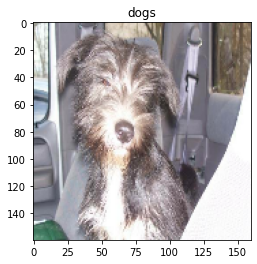

In [13]:
plt.imshow(first_image.numpy().astype("uint8"))
plt.title(class_names[first_label])

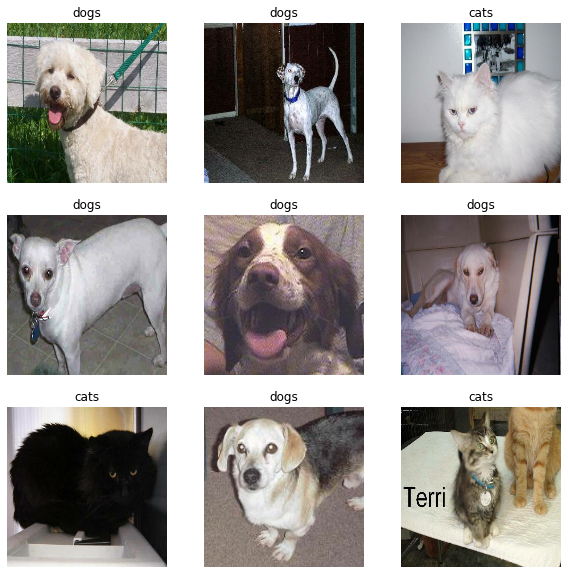

In [14]:
# disply 

#take one batch, 32 items

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [15]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [16]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Configure the dataset for performance

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

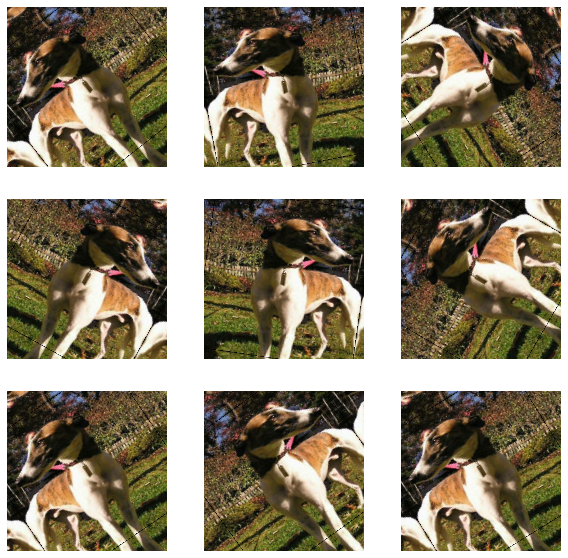

In [19]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescale pixel values

I will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel vaues in [-1,1], but at this point, the pixel values in your images are in [0-255]. To rescale them, use the preprocessing method included with the model.

In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [21]:
# Note: Alternatively, you could rescale pixel values from [0,255] to [-1, 1] using a Rescaling layer.


rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Create the base model from the pre-trained convnets

I will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [22]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


**This feature extractor converts each 160x160x3 image into a 5x5x1280**

In [23]:
#  see what it does to an example batch of images

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Feature extraction

will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

## Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them

In [24]:
base_model.trainable = False


## Important note about BatchNormalization layers

Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning

When you set `layer.trainable = False`, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model the model has learned

In [25]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single 1280-element vector per image

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a **logit**, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0

In [27]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


**Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.**

In [30]:
inputs=tf.keras.Input(shape=IMG_SHAPE)

x=data_augmentation(inputs)
x=preprocess_input(x)

x=base_model(x, training=False)

x=global_average_layer(x)
x=tf.keras.layers.Dropout(0.20)(x)
outputs=prediction_layer(x)

model=tf.keras.Model(inputs, outputs)

## Compile the model

Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output

In [31]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

there are 1.2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases

In [34]:
print(len(model.trainable_variables))

2


## Train the model

In [35]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 18s 707ms/step - loss: 0.8637 - accuracy: 0.4389


In [36]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.44


In [38]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 63s 993ms/step - loss: 0.2180 - accuracy: 0.9000 - val_loss: 0.1266 - val_accuracy: 0.9592
Epoch 2/10
63/63 [==============================] - 63s 1s/step - loss: 0.2138 - accuracy: 0.9075 - val_loss: 0.1245 - val_accuracy: 0.9641
Epoch 3/10
63/63 [==============================] - 64s 1s/step - loss: 0.2077 - accuracy: 0.9035 - val_loss: 0.1167 - val_accuracy: 0.9653
Epoch 4/10
63/63 [==============================] - 63s 1s/step - loss: 0.1935 - accuracy: 0.9170 - val_loss: 0.1116 - val_accuracy: 0.9666
Epoch 5/10
63/63 [==============================] - 66s 1s/step - loss: 0.1885 - accuracy: 0.9170 - val_loss: 0.1068 - val_accuracy: 0.9691
Epoch 6/10
63/63 [==============================] - 63s 1s/step - loss: 0.1832 - accuracy: 0.9260 - val_loss: 0.1047 - val_accuracy: 0.9691
Epoch 7/10
63/63 [==============================] - 63s 995ms/step - loss: 0.1745 - accuracy: 0.9290 - val_loss: 0.0937 - val_accuracy: 0.9752
Epoch 8/10
63/

## Learning curves

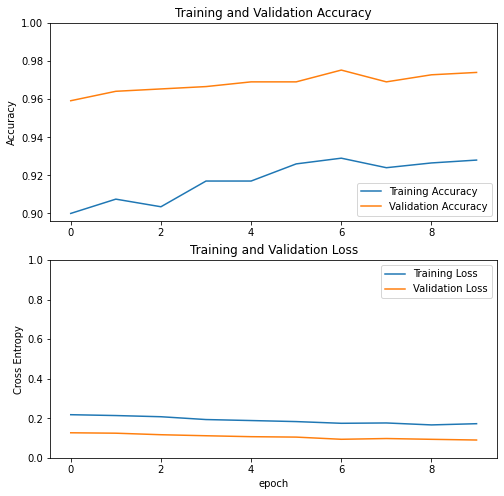

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. ** The weights of the pre-trained network were not updated during training**. 

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

***Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.***


Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

## Un-freeze the top layers of the model

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training

In [40]:
base_model.trainable = True


In [41]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


# Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [42]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [43]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [44]:
len(model.trainable_variables)


56

## Continue training the model

In [45]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 96s 2s/step - loss: 0.1741 - accuracy: 0.9216 - val_loss: 0.0704 - val_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 91s 1s/step - loss: 0.1225 - accuracy: 0.9535 - val_loss: 0.0617 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 93s 1s/step - loss: 0.1014 - accuracy: 0.9618 - val_loss: 0.0454 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 90s 1s/step - loss: 0.1029 - accuracy: 0.9562 - val_loss: 0.0384 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 90s 1s/step - loss: 0.0978 - accuracy: 0.9653 - val_loss: 0.0436 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 90s 1s/step - loss: 0.0830 - accuracy: 0.9667 - val_loss: 0.0462 - val_accuracy: 0.9876
Epoch 16/20
63/63 [==============================] - 91s 1s/step - loss: 0.0717 - accuracy: 0.9737 - val_loss: 0.0323 - val_accuracy: 0.9889
Epoch 17/20
6

In [46]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

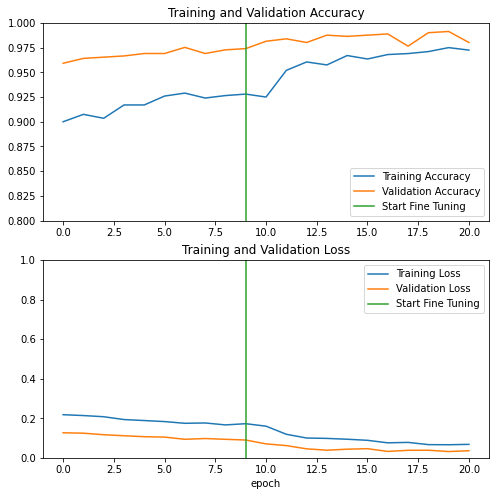

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

In [48]:
# Finaly you can verify the performance of the model on new data using test set.

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 4s 708ms/step - loss: 0.0119 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


In [57]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

In [58]:
len(image_batch)

32

In [59]:
predictions

array([-9.325879  ,  9.48869   , -8.475     , -5.629336  ,  5.725451  ,
       -5.7174487 , -6.0732894 , -8.093171  ,  4.3290997 ,  4.1442895 ,
       10.145622  , -6.0811896 , -5.595223  , -7.834053  ,  0.07584129,
       -9.257451  ,  5.537527  , 10.549569  , -9.73997   , -9.2589445 ,
        8.132023  , -8.979367  , -8.035501  ,  6.536349  ,  6.767039  ,
       -8.089488  , -7.7963023 ,  8.639796  ,  6.1679473 , -4.0203924 ,
        6.7259564 , -9.857203  ], dtype=float32)

In [60]:
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions


<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([8.9088608e-05, 9.9992430e-01, 2.0861626e-04, 3.5780668e-03,
       9.9674869e-01, 3.2773018e-03, 2.2982955e-03, 3.0550361e-04,
       9.8699200e-01, 9.8439276e-01, 9.9996072e-01, 2.2801757e-03,
       3.7018359e-03, 3.9592385e-04, 5.1895124e-01, 9.5398180e-05,
       9.9607921e-01, 9.9997377e-01, 5.8882288e-05, 9.5255811e-05,
       9.9970603e-01, 1.2597442e-04, 3.2359362e-04, 9.9855232e-01,
       9.9885023e-01, 3.0669570e-04, 4.1109324e-04, 9.9982309e-01,
       9.9790883e-01, 1.7629504e-02, 9.9880213e-01, 5.2368647e-05],
      dtype=float32)>

In [61]:
predictions = tf.where(predictions < 0.5, 0, 1)
predictions

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0], dtype=int32)>

Predictions Labels:
 [0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0]
True Labels:
 [0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0]


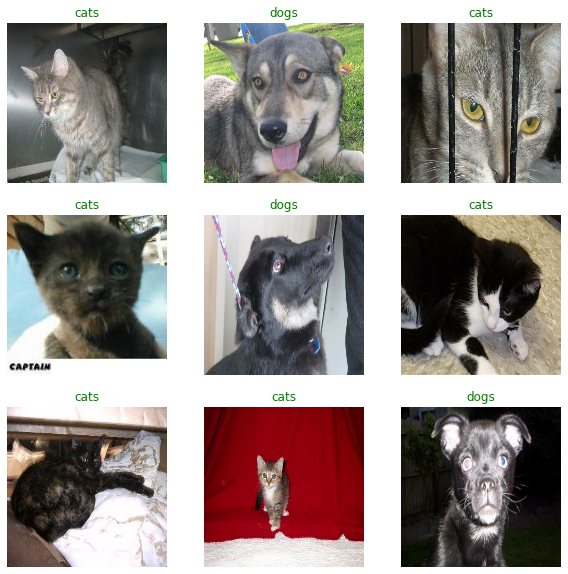

In [64]:



print('Predictions Labels:\n', predictions.numpy())
print('True Labels:\n', label_batch)



plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)

  if predictions[i] == label_batch[i]:
    color = "green"
  else:
    color = "red"

  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]], color=color)
  plt.axis("off")